## When does the system converge?
This notebook directly compares the evolution of the autonomous and non-autonomous systems and records the time at which the two simulations become indistinguishable within a specified tolerance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os
import math

### One-step update in the system's evolution
Both the autonomous and non-autonomous systems are implemented.

In [2]:
#Non autonomous
def one_step(t, dt, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par

    for i in range(len(H)):

        ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new)
        ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new)
        ev_M(i, dt, d_M, k3, M_i, M, D, M_new)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        R_new[i] = 100 - N_new[i] - D_new[i]

#Autonomous
def one_step_autonomous(dt, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par

    for i in range(len(H)):

        ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new)
        ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new)
        ev_M(i, dt, d_M, k3, M_i, M, D, M_new)
        ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new)
        ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new)
        R_new[i] = 100  - N_new[i] - D_new[i]

### Damage function

In [3]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Evolution of the immune cells
This notebook is intended to study the homogeneous scenario; diffusion is not implemented.

In [4]:
def ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new):
    H_new[i] = H[i] + dt * (k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))

def ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new):
    C_new[i] = C[i] + dt * (k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
   
def ev_M(i, dt, d_M, k3, M_i, M, D, M_new):
    M_new[i] = M[i] + dt * (k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))

### Evolution of the composition of muscle tissue

In [5]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))

def ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * k5 * C[i])
        
def ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * k5 * C[i] - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])

### Save the output to a .csv file

In [6]:
def save_to_csv(output_list, column_name, directory, file_name):
    os.makedirs(directory, exist_ok=True)
    
    file_path = os.path.join(directory, file_name)
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

    df[column_name] = output_list
    
    df.to_csv(file_path, index=False)

### Function to retrieve information from the configuration file

In [7]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

### Relative Tolerance
Check if the difference between two values is small relative to their magnitude.

In [8]:
def relative_tolerance(a, b, tolerance):
    return abs(a - b) <= tolerance * max(abs(a), abs(b))

### Define which kind of state variable one is working with (tissue or immune cells)
This function recognises whether or not the given variable is a type of fibre in muscle tissue.

In [9]:
def is_muscle_tissue(var):
    if var in ['N', 'D', 'R']:
        return True
    else:
        return False

### Simulation

The purpose of this simulation is to determine the time at which a specified convergence condition is met, given a particular initial condition. Standard initial conditions are extracted from the configuration file, along with other useful parameters. Subsequently, a single state variable, stored in 'var', is selected, and a list of plausible initial values for this variable is constructed. The initial condition for this specific variable is then updated, and for each new value, the code identifies the time of convergence for the system.

The convergence condition is defined as follows: when the autonomous and non-autonomous systems reach the same configuration at a specific time, a tentative time of convergence is recorded. Before this value is stored, however, the evolution continues for a number of steps defined by 'countdown'. If, during this time, the two systems remain overlapping (within a specified tolerance) and the values of all state variables do not change significantly (as determined by a second tolerance), the tentative time is stored. Otherwise, the evolution proceeds until another plausible time of convergence is identified. An upper limit for this search is set by t_max.

Names with '_a' refer to the autonomous system.

In [41]:
#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config_t_conv.ini')

#Parameters
i_c = extract_values('initial_conditions', config)
i_c_stored = i_c.copy() #keeps track of the initial condition specified in config_t_conv.ini
par = extract_values('parameters', config)
sim = extract_values('simulation_par', config)
dt, t_min, t_max, N_cells, tolerance_1, tolerance_2 = sim
N_cells = int(N_cells)

'''The broader values from the paper are as follows, but they can be adjusted to focus on a region of particular interest.'''
bounds = [(0, 4500), (0, 450), (0, 100000), (0, 100), (0, 100), (0, 100)]
num_samples = [101, 101, 101, 101, 101, 101]
var = 'M'
is_percentage = is_muscle_tissue(var)

n_vars = 6
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']
var_map = {
    'H': 0,
    'C': 1,
    'M': 2,
    'N': 3, 
    'D': 4, 
    'R': 5
}

#Sample the chosen state variable in the predefined bounds
sample = np.linspace(*bounds[var_map[var]], num_samples[var_map[var]])
#Select the index of the sample for which the evolution will be plotted
i_c_plot = 3

time_steps = np.linspace(t_min, t_max, int((t_max - t_min) / dt) + 1)

remaining_vars = []    
for choice in var_map.keys():
    if choice != var:
        remaining_vars.append(choice)

t_convergence = [] #store the output of the simulation
fail_index = []
for i in range(num_samples[var_map[var]]):
    '''At each iteration, the system is reset to its original state and the initial
condition for the variable "var" is then updated.'''
    i_c = i_c_stored.copy()
    i_c[var_map[var]] = sample[i]

    '''Mass conservation must be maintained in the initial conditions,
so if N_i, D_i or R_i are changed, the others must be adjusted accordingly'''
    if is_percentage:
        second, third = remaining_vars[3:5] #the last two variables are the ones referring to muscle tissue
        if 100 - i_c[var_map[var]] - i_c[var_map[second]] >= 0:
            i_c[var_map[third]] = 100. - i_c[var_map[var]] - i_c[var_map[second]]
        elif 100 - i_c[var_map[var]] - i_c[var_map[third]] >= 0:
            i_c[var_map[second]] = 100. - i_c[var_map[var]] - i_c[var_map[third]]
        else:
            i_c[var_map[second]] = 100. - i_c[var_map[var]]
            i_c[var_map[third]] = 0.

#State variables, initial conditions and update lists
    H, C, M, N, D, R = [[i_c[k]] * N_cells for k in range(6)]
    H_a, C_a, M_a, N_a, D_a, R_a = [[i_c[k]] * N_cells for k in range(6)]
    H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[k]] * N_cells for k in range(6)]
    H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[k]] * N_cells for k in range(6)]
    H_new_a, C_new_a, M_new_a, N_new_a, D_new_a, R_new_a = [[i_c[k]] * N_cells for k in range(6)]

    if i == i_c_plot:
#List of N_cells values for each state variable, used to store the evolution at each time step
        H_values = [i_c[0]]
        C_values = [i_c[1]]
        M_values = [i_c[2]]
        N_values = [i_c[3]]
        D_values = [i_c[4]]
        R_values = [i_c[5]]
        
        H_values_a = [i_c[0]]
        C_values_a = [i_c[1]]
        M_values_a = [i_c[2]]
        N_values_a = [i_c[3]]
        D_values_a = [i_c[4]]
        R_values_a = [i_c[5]]

    check = False
    countdown = 200
    for time in time_steps:

        H_check = H.copy()
        C_check = C.copy()
        M_check = M.copy()
        N_check = N.copy()
        D_check = D.copy()
        R_check = R.copy()
        
        one_step(time, dt, H, C, M, N, D, R, 
                H_new, C_new, M_new, N_new, D_new, R_new, 
                H_i, C_i, M_i, par)

        one_step_autonomous(dt, H_a, C_a, M_a, N_a, D_a, R_a,
                            H_new_a, C_new_a, M_new_a, N_new_a, D_new_a, R_new_a,
                            H_i, C_i, M_i, par)
        
        if i == i_c_plot:
            H_values.append(H_new[1])
            C_values.append(C_new[1])
            M_values.append(M_new[1])
            N_values.append(N_new[1])
            D_values.append(D_new[1])
            R_values.append(R_new[1])
            
            H_values_a.append(H_new_a[1])
            C_values_a.append(C_new_a[1])
            M_values_a.append(M_new_a[1])
            N_values_a.append(N_new_a[1])
            D_values_a.append(D_new_a[1])
            R_values_a.append(R_new_a[1])


        '''To meet the desired condition, the evolution of the autonomous and non-autonomous systems must be the same,
within a certain tolerance specified by the variable "tolerance".'''
        condition_auto_vs_non = relative_tolerance(H_new[1], H_new_a[1], tolerance_1) and \
                                relative_tolerance(C_new[1], C_new_a[1], tolerance_1) and \
                                relative_tolerance(M_new[1], M_new_a[1], tolerance_1) and \
                                relative_tolerance(N_new[1], N_new_a[1], tolerance_1) and \
                                relative_tolerance(D_new[1], D_new_a[1], tolerance_1) and \
                                relative_tolerance(R_new[1], R_new_a[1], tolerance_1)
        '''Moreover, the system's configuration at t and at t+1 must not differ significantly.'''
        condition_convergence = relative_tolerance(H_new[1], H[1], tolerance_2) and \
                                relative_tolerance(C_new[1], C[1], tolerance_2) and \
                                relative_tolerance(M_new[1], M[1], tolerance_2) and \
                                relative_tolerance(N_new[1], N[1], tolerance_2) and \
                                relative_tolerance(D_new[1], D[1], tolerance_2) and \
                                relative_tolerance(R_new[1], R[1], tolerance_2)
        
        if not check and condition_auto_vs_non:
            check = True
            t_conv = time
            
        '''time_convergence does not simply represent a crossing of the two trends (autonomous vs non-autonomous),
but actually marks the point from which the evolutions remain consistently close.
When the condition for near-overlap is met at a certain time step, the evolution is not immediately interrupted.
Instead, it continues for additional steps to verify if the subsequent steps also satisfy the same condition.
In order to consider convergence achieved, the evolution must also proceed slowly at each step.
'''
        if check and condition_auto_vs_non and condition_convergence:
            countdown = countdown - 1
        elif check and (not condition_auto_vs_non or not condition_convergence):
            check = False
            countdown = 200
                                
        if countdown <= 0:
            t_convergence.append(t_conv)
            if i == i_c_plot:
                index = np.where(time_steps == t_conv)[0][0]
            break

        H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()
        H_a, C_a, M_a, N_a, D_a, R_a = H_new_a.copy(), C_new_a.copy(), M_new_a.copy(), N_new_a.copy(), D_new_a.copy(), R_new_a.copy()
        
        if time == time_steps[-1]:
            print(f'{i} Simulation stopped before reaching the desired t_convergence for {var}_i = {sample[i]}')
            fail_index.append(i)

working_indexes = [i for i in list(range(num_samples[var_map[var]])) if i not in fail_index]
directory = f'sample_{var}i/dt_{dt}_tol1_{tolerance_1}_tol2_{tolerance_2}/'

7 Simulation stopped before reaching the desired t_convergence for M_i = 7000.0
8 Simulation stopped before reaching the desired t_convergence for M_i = 8000.0
9 Simulation stopped before reaching the desired t_convergence for M_i = 9000.0
10 Simulation stopped before reaching the desired t_convergence for M_i = 10000.0
11 Simulation stopped before reaching the desired t_convergence for M_i = 11000.0
12 Simulation stopped before reaching the desired t_convergence for M_i = 12000.0
13 Simulation stopped before reaching the desired t_convergence for M_i = 13000.0
14 Simulation stopped before reaching the desired t_convergence for M_i = 14000.0
15 Simulation stopped before reaching the desired t_convergence for M_i = 15000.0
16 Simulation stopped before reaching the desired t_convergence for M_i = 16000.0
17 Simulation stopped before reaching the desired t_convergence for M_i = 17000.0
18 Simulation stopped before reaching the desired t_convergence for M_i = 18000.0
19 Simulation stopped 

The following cell is not strictly necessary for the purpose of the notebook. However, it provides the opportunity to visualise the evolution of both the autonomous and non-autonomous systems from t_min to convergence (if the convergence conditions were indeed met for the specific initial condition displayed, which was chosen in the previous cell using the variable i_c_plot).

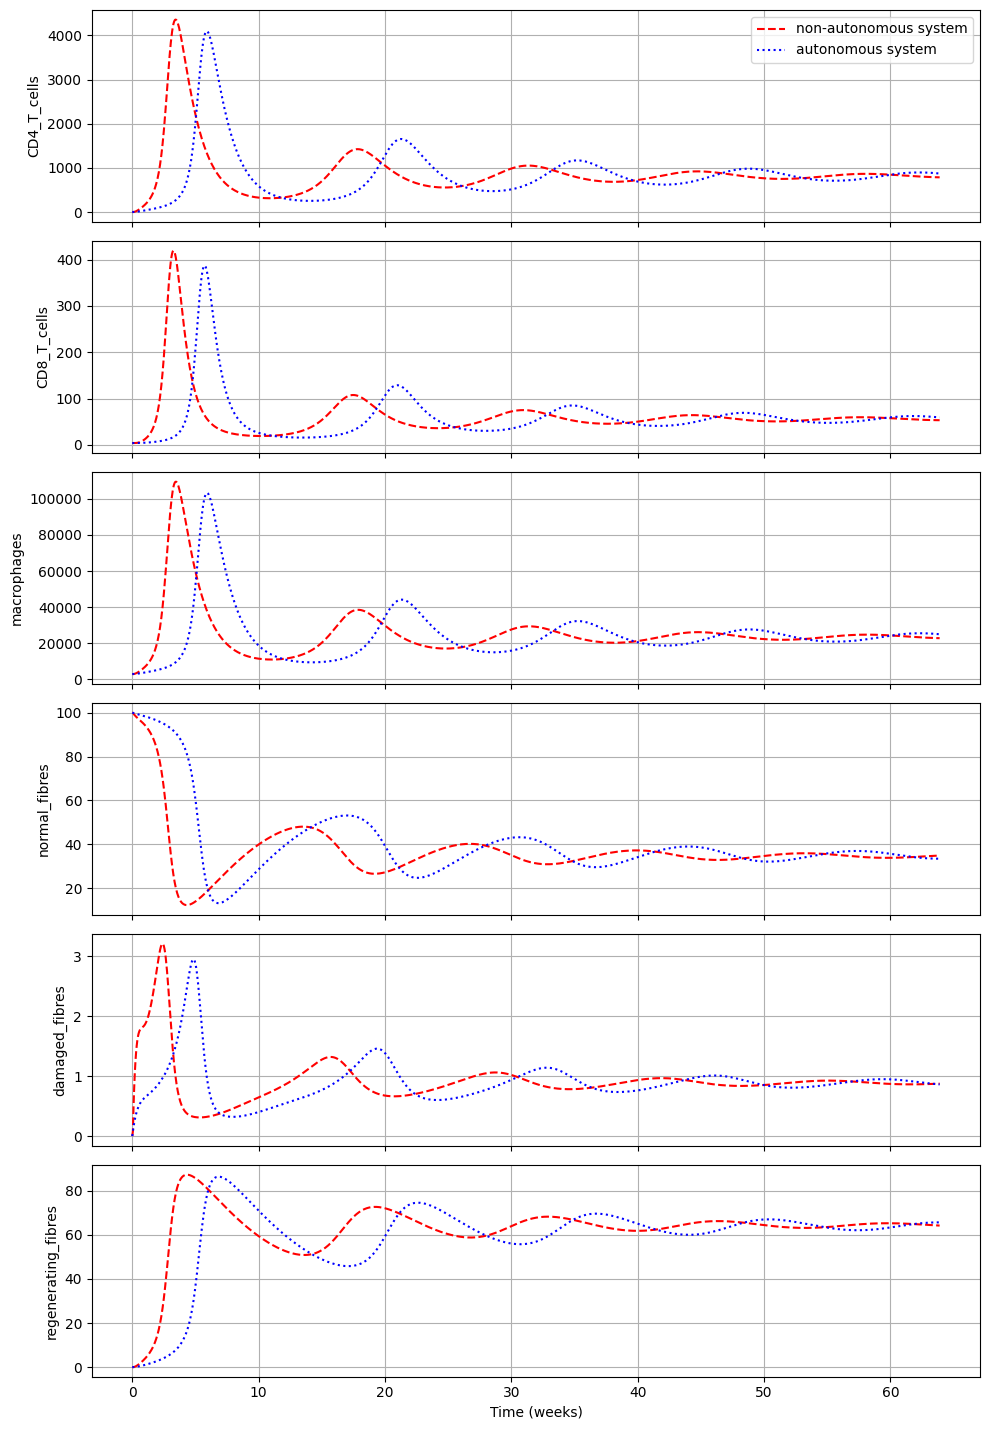

In [42]:
'''Since we only want to stop plotting at time_convergence, the output from the subsequent steps must be discarded;
this is the reason why all lists are sliced.'''
if i_c_plot in working_indexes:
    t_plot = time_steps[:index + 1]    

    first_cell_ev = [H_values[:index + 1], C_values[:index + 1], M_values[:index + 1], N_values[:index + 1], D_values[:index + 1], R_values[:index + 1]]
    first_cell_ev_a = [H_values_a[:index + 1], C_values_a[:index + 1], M_values_a[:index + 1], N_values_a[:index + 1], D_values_a[:index + 1], R_values_a[:index + 1]]
    
    fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)
    
    for i in range(n_vars): 
        axes[i].plot(t_plot, first_cell_ev[i], label='non-autonomous system', color='r', linestyle='--')
        axes[i].plot(t_plot, first_cell_ev_a[i], label='autonomous system', color='b', linestyle=':')
        axes[i].set_ylabel(labels[i])
        axes[i].grid(True)
    
    axes[-1].set_xlabel('Time (weeks)')
    axes[0].legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    #plt.savefig('until_convergence_autonomous_vs_non')
    
    plt.show()

Run the following cell to plot the previously determined times of convergence as a function of the initial value of the variable var. The output can be saved in .csv format by setting save_csv to True.

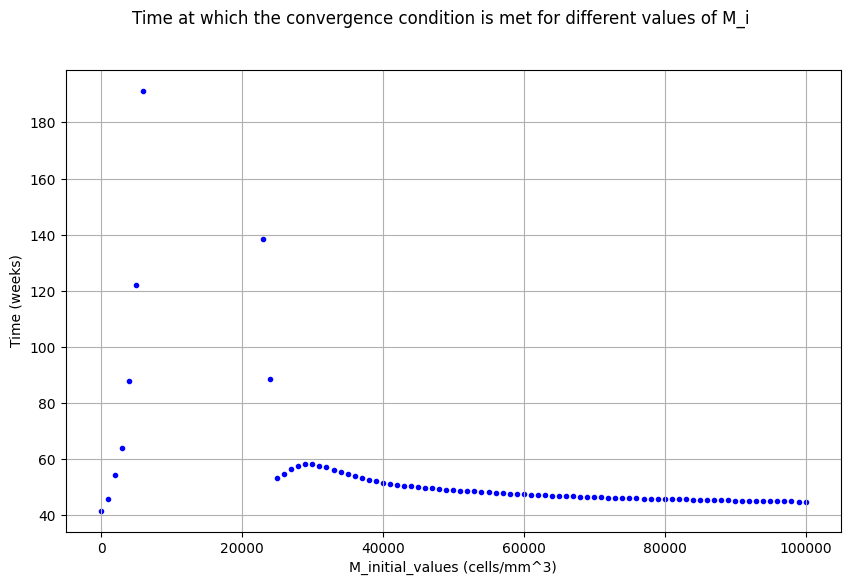

In [43]:
x_values = [sample[i] for i in working_indexes]
y_values = t_convergence

save_csv = True
if save_csv == True:
    
    save_to_csv(x_values, f'{var}i', directory, f'{var}i_stationary_time.csv')
    save_to_csv(y_values, 't_convergence (weeks)', directory, f'{var}i_stationary_time.csv')

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, marker='.', linestyle='-', color='b')

plt.xlabel(f'{var}_initial_values (cells/mm^3)')
plt.ylabel('Time (weeks)')
plt.grid(True)

plt.suptitle(f'Time at which the convergence condition is met for different values of {var}_i')

filename = f't_convergence_{var}i_in_{bounds[var_map[var]][0]}_{bounds[var_map[var]][1]}'
filepath = directory + filename
plt.savefig(filepath)

plt.show()